# MicroTask 2

###  Produce a chart showing the distribution of time-to-close (using the corresponding field in the GrimoireLab enriched index for GitHub issues) for issues already closed, and opened during the last six months.

In [1]:
#Importing Libraries 

from datetime import datetime
import elasticsearch
import elasticsearch_dsl
from pprint import pprint
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from pandas.tools.plotting import table


In [2]:
enrich_index_name = 'github'
raw_index_name = 'github_raw'

es = elasticsearch.Elasticsearch('http://localhost:9200/',  verify_certs=False)

github_token = "6ee78bdbfde11ffd95c0c1b22ed5bc1a6f1fd52a"


In [3]:
# if(es.indices.exists(enrich_index_name)):
#     es.indices.delete(enrich_index_name)

# if(es.indices.exists(raw_index_name)):
#     es.indices.delete(raw_index_name)


In [17]:
subprocess.run(['p2o.py', '--enrich', '--index', raw_index_name,
      '--index-enrich', enrich_index_name, '-e', 'http://localhost:9200/',
      '--no_inc', '--debug', 'github', 'grimoirelab' , 'perceval',
      '-t', github_token, '--sleep-for-rate'])


CompletedProcess(args=['p2o.py', '--enrich', '--index', 'github_raw', '--index-enrich', 'github', '-e', 'http://localhost:9200/', '--no_inc', '--debug', 'github', 'grimoirelab', 'perceval', '-t', '6ee78bdbfde11ffd95c0c1b22ed5bc1a6f1fd52a', '--sleep-for-rate'], returncode=1)

In [18]:
response = es.search(index=enrich_index_name)
Number_of_commits = response['hits']['total']
print("Total Number of commits :- %s" %(Number_of_commits))
response = es.search( index=enrich_index_name , body={"size":Number_of_commits} )

# for i in response['hits']['hits']:
#     pprint(i['_source'])


Total Number of commits :- 362


In [19]:
 request = elasticsearch_dsl.Search(using=es, index=enrich_index_name)
request = request.source(['created_at', 'closed_at', 'time_open_days' , 'time_to_close_days' , 'item_type' , 'id_in_repo'])
request = request.filter("terms", item_type = ['issue'])
request = request.filter('range', created_at ={'gte': 'now-6M'})
request = request.sort({'created_at':{'order':'asc'}})
request = request[0:10000]
result = request.execute()


In [20]:
# pprint(result.to_dict())
result = result.to_dict()
data = []

for i in result['hits']['hits']:
    data.append(i['_source'])

# pprint(data)


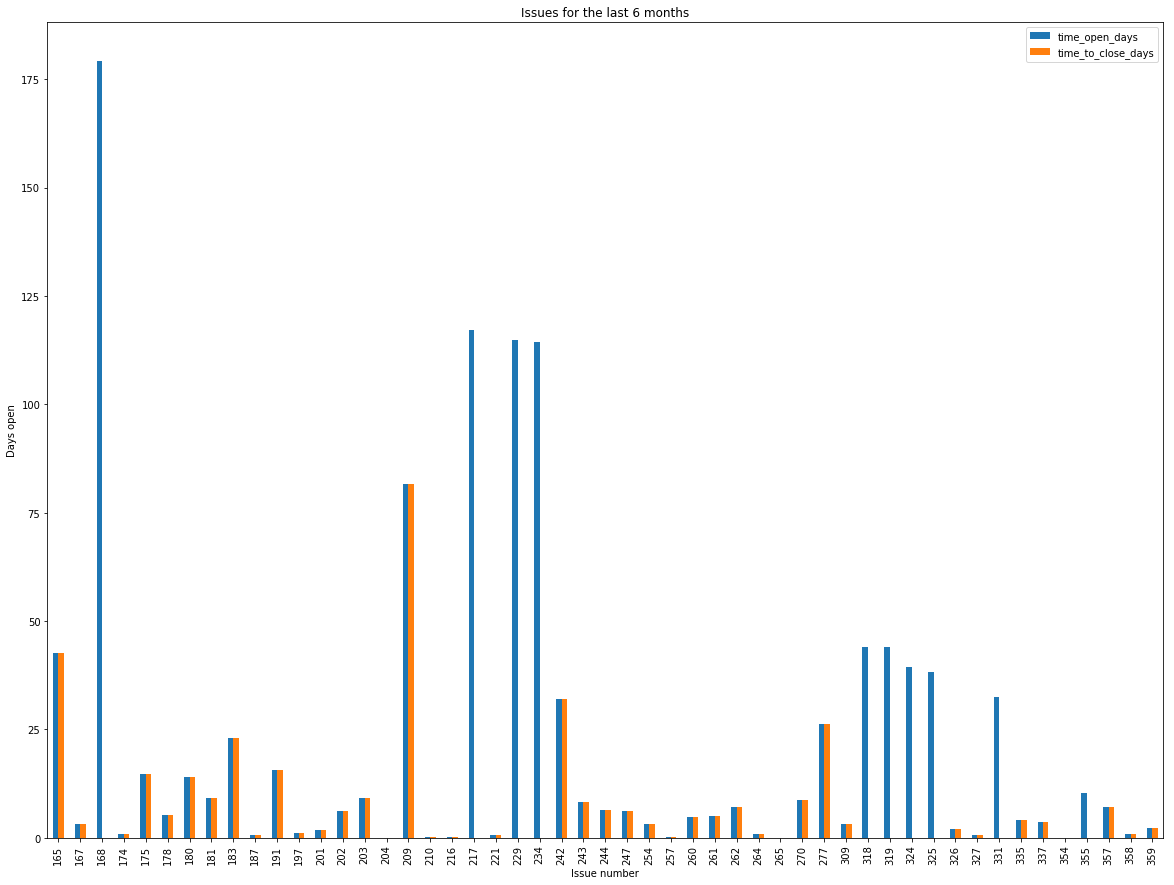

In [26]:
df = pd.DataFrame(data)
df = df.fillna(0)
df.index = range(1,len(df.index)+1)
ax = df.plot(x=df['id_in_repo'], kind='bar', figsize=(20, 15))
ax.set_title('Issues for the last 6 months')
ax.set_xlabel('Issue number')
ax.set_ylabel('Days open')
plt.savefig('graph.png', bbox_inches='tight')
plt.show()


,closed_at,created_at,id_in_repo,item_type,time_open_days,time_to_close_days
1,2017-11-07T12:07:50Z,2017-09-25T21:02:07Z,165,issue,42.63,42.63
2,2017-09-29T17:21:43Z,2017-09-26T15:04:45Z,167,issue,3.10,3.10
3,0,2017-09-27T11:44:00Z,168,issue,179.17,0.00
4,2017-10-10T14:27:30Z,2017-10-09T16:20:16Z,174,issue,0.92,0.92
5,2017-10-24T12:30:36Z,2017-10-09T18:22:00Z,175,issue,14.76,14.76
6,2017-10-16T19:13:11Z,2017-10-11T12:24:04Z,178,issue,5.28,5.28
7,2017-10-30T10:15:59Z,2017-10-16T10:48:08Z,180,issue,13.98,13.98
8,2017-10-25T17:41:25Z,2017-10-16T13:33:20Z,181,issue,9.17,9.17
9,2017-11-08T18:46:02Z,2017-10-16T17:34:48Z,183,issue,23.05,23.05
10,2017-10-25T08:09:05Z,2017-10-24T19:27:29Z,187,issue,0.53,0.53


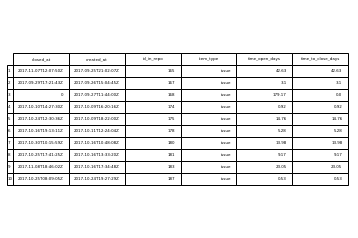

In [30]:
df.to_csv('Issues.csv')

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis


table(ax,df.head(10) , loc='center' )
plt.savefig('Issues.png' , bbox_inches = 'tight' )
df.head(10)